In [1]:
%matplotlib inline
import pdb, sys, os
sys.path.insert(0, './core/')

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 5]

from functools import partial
from collections import defaultdict

np.set_printoptions(suppress=True, linewidth=120, precision=4)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from typing import List, TypeVar
Tensor = TypeVar('torch.tensor')

class VAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List[int] = None) -> None:
        '''
        expected input image size is 28*28
        '''
        super().__init__()
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size = 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            p = 0 if i == 1 else 1
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size = 3,
                                       stride = 2,
                                       padding = 1,
                                       output_padding = p ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Sigmoid())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        # pdb.set_trace()
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self, n, device = 'cuda:0'):
        z = torch.randn(n, self.latent_dim)
        return self.decode(z.to(device))


In [3]:
class VAE_Wrapper:
    def __init__(self, epoches = 100, batchsize = 500, 
                 maxlr = 0.01, wd = 1e-5, device = 'cuda:0') -> None:
        self.epoches = epoches
        self.batchsize = batchsize
        self.maxlr = maxlr
        self.device = device
        self.wd = wd

    def fit(self, X, latent_dim = 20, weight_schedule = None):
        # input X is assume to be a 2d numpy array of N, 28*28
        N, D = X.shape
        assert( D == 28 * 28 ), "Not Implemented for general input shape!"
        
        model = VAE(1, latent_dim)
        model.to(self.device)
        
        optimizer = optim.Adam(model.parameters(), weight_decay = self.wd)
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.maxlr, anneal_strategy='cos', 
                            pct_start=0.25, epochs=self.epoches, steps_per_epoch = 1, verbose = False)
        loss_func = model.loss_function
        
        X = torch.from_numpy(X).to(self.device)
        X = X.view(N,1,28,28)
        train_loader = DataLoader(X, batch_size=self.batchsize, shuffle=True, drop_last=True)
        
        model.train()
        for e in range(self.epoches):
            epoch_loss = 0.0
            
            if weight_schedule:
                kld_w = weight_schedule(e)
            else:
                kld_w = 0.1
            
            for data in train_loader:
                optimizer.zero_grad()
                out = model(data)
                loss = loss_func( *out, M_N = kld_w )['loss']
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            scheduler.step()
            print('Epoch:{} loss:{}'.format(e+1, epoch_loss) ,end = '\r')
        print('')
            
        model.eval()
        self.model = model
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            
        N = X.shape[0]
        X = X.to(self.device, dtype = torch.float32)
        
        with torch.no_grad():
            ret = self.model.encode(X.view(N,1,28,28))[0]
        return ret.cpu().numpy()

    def inverse_transform(self, F):
        if isinstance(F, np.ndarray):
            F = torch.from_numpy(F)
        
        F = F.to(self.device, dtype = torch.float32)
        with torch.no_grad():
            ret = self.model.decode(F)
            ret = torch.flatten(ret, start_dim = 1)
        return ret.cpu().numpy()

In [4]:
# mnist data processing block
ENDIAN = 'big'
MAX_VAL = 255.0
MNIST_IMG_SIZE = (28,28)

def read_images(fname, down_sample):
    f = open(fname,'rb')
    assert( int.from_bytes(f.read(4),ENDIAN) == 2051 )
    N = int.from_bytes(f.read(4),ENDIAN)
    row_size = int.from_bytes(f.read(4),ENDIAN)
    col_size = int.from_bytes(f.read(4),ENDIAN)
    buf = f.read(N*row_size*col_size)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32).reshape(N, row_size * col_size)
    f.close()

    # flatten the image and downsample a little bit, normalize to 0-1
    ret = []
    for row in data:
        img = row.reshape(row_size,col_size)

        if down_sample:
            img = block_reduce(img, (2,2), np.max)

        ret.append(img.flatten()/MAX_VAL)
    return np.array(ret)

def read_label(fname):
    f = open(fname,'rb')
    assert( int.from_bytes(f.read(4),ENDIAN) == 2049 )
    N = int.from_bytes(f.read(4),ENDIAN)
    buf = f.read(N)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    f.close()
    return data

mnist_dir = './data/digits/mnist/'
train_image = f'{mnist_dir}/train-images.idx3-ubyte'
train_label = f'{mnist_dir}/train-labels.idx1-ubyte'
test_image = f'{mnist_dir}/t10k-images.idx3-ubyte'
test_label = f'{mnist_dir}/t10k-labels.idx1-ubyte'


Xtr = read_images(train_image, False)
ytr = read_label(train_label)
Xte = read_images(test_image, False)
yte = read_label(test_label)

# stack all mnist data for training auto encoder
# train_data = np.vstack([Xtr,Xte])
train_data = Xtr
np.random.shuffle(train_data)


(60000, 784)


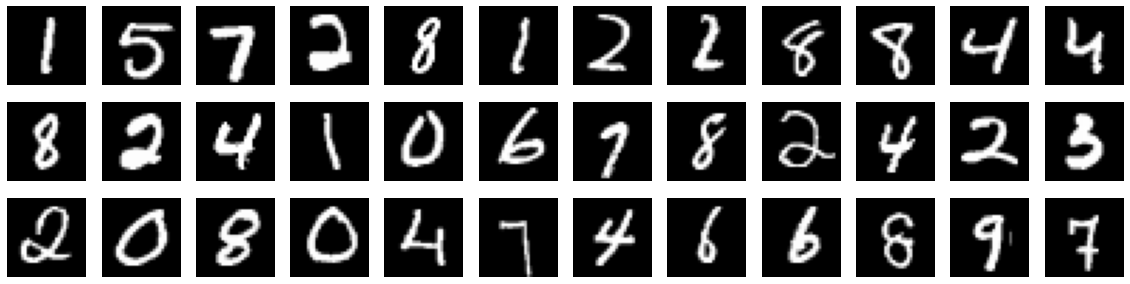

In [5]:
# check the load of mnist is correct 
print(train_data.shape)
# random visualize some samples 

VIS_ROWS = 3
VIS_COLS = 12
plt.rcParams['figure.figsize'] = [20, 5]

def visualize_images(img_array, selected, process = lambda x:x.reshape(*MNIST_IMG_SIZE)):
    k = 1
    fid = plt.figure()
    for i in range(VIS_ROWS):
        for j in range(VIS_COLS):
            plt.subplot(VIS_ROWS,VIS_COLS,k)
            plt.imshow(process(img_array[selected[k-1]]), cmap='gray' )
            plt.axis('off')
            k += 1

    plt.show()

selected = np.random.choice(train_data.shape[0], VIS_ROWS*VIS_COLS, replace = False)
visualize_images(train_data, selected)

In [6]:
# this block process the dida digits dataset
PER_CLASS = 30
dida_dir = './data/digits/dida'
dida_images = []

for label in range(10):
    img_files = glob.glob(f'{dida_dir}/{label}/*.jpg')
    for i in range(PER_CLASS):
        dida_images.append( plt.imread(img_files[i]) )


# visualize 
selected = np.random.choice(len(dida_images), VIS_ROWS*VIS_COLS, replace = False)
# visualize_images(dida_images, selected, process = lambda x:x)

In [7]:
# convert dida images into mnist form (i.e, grey scale 28*28 image)
import cv2

def transform_to_mnist(img_rgb):
    img_gray = 0.21 * img_rgb[:,:,0] + 0.72 * img_rgb[:,:,1] + 0.07 * img_rgb[:,:,2]
    # img_gray = img_rgb.mean(axis=2)
    
    scaled_img = cv2.resize(img_gray, MNIST_IMG_SIZE , interpolation=cv2.INTER_AREA)
    assert(np.max(scaled_img) <= 255)
    scaled_img = scaled_img / MAX_VAL
    scaled_img = scaled_img.flatten()
    scaled_img = scaled_img.astype(np.float32)
    return scaled_img
    
# convert and visualize again
dida_img = np.array(list(map(transform_to_mnist, dida_images)))
# visualize_images(dida_img, selected)

In [8]:
# this block process the chars74k dataset
ch74_dir = './data/digits/chars74k'
ch74_images = []
PER_CLASS = 30
for label in range(10):
    img_files = glob.glob('{}/Sample0{:02d}/*.png'.format(ch74_dir, label+1))
    for i in range(PER_CLASS):
        ch74_images.append( plt.imread(img_files[i]) )

# visualize 
selected = np.random.choice(len(ch74_images), VIS_ROWS*VIS_COLS, replace = False)
# visualize_images(ch74_images, selected, process = lambda x:x)

In [9]:
# convert char74 images into mnist form (i.e, grey scale 28*28 image) 

# convert and visualize again
# this dataset is already in 0-1
ch74_img = np.array(list(map(transform_to_mnist, ch74_images))) * MAX_VAL
# visualize_images(ch74_img, selected)

In [10]:
# enhance the mnist data with reversed pixel color 
mnist_train = np.vstack([train_data, 1-train_data])
np.random.shuffle(mnist_train)
print(mnist_train.shape)

(120000, 784)


In [11]:
# train vanilla auto encoder
from utmLib import utils

max_epoch = 250
latent_dim = 5
AE_SAVE_PATH = 'output/vae-mnist-e{}-d{}.pkl'.format(max_epoch, latent_dim)

if 1 and os.path.exists(AE_SAVE_PATH):
    ae = utils.pkload(AE_SAVE_PATH)
else:
    weight_schedule = lambda e: 5e-4 
    ae = VAE_Wrapper(epoches = max_epoch, maxlr = 2e-3, 
                     wd = 0, device = 'cuda:1',batchsize = 1024).fit(mnist_train, 
                                                                       latent_dim = latent_dim,
                                                                       weight_schedule = weight_schedule)
    utils.pkdump(ae, AE_SAVE_PATH)

########################################################################################################################


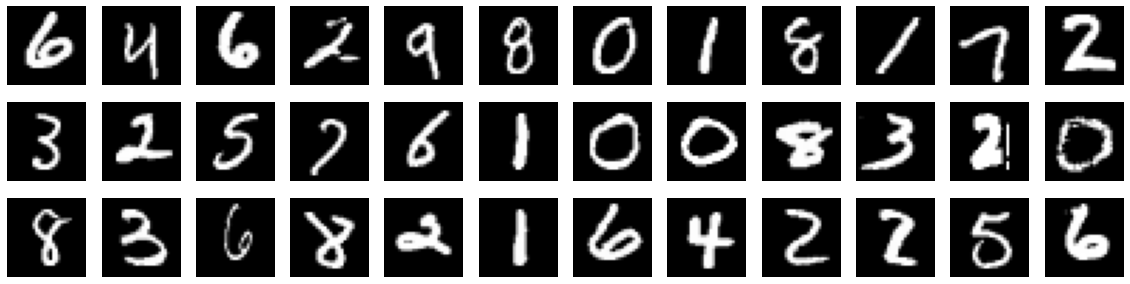

------------------------------------------------------------------------------------------------------------------------


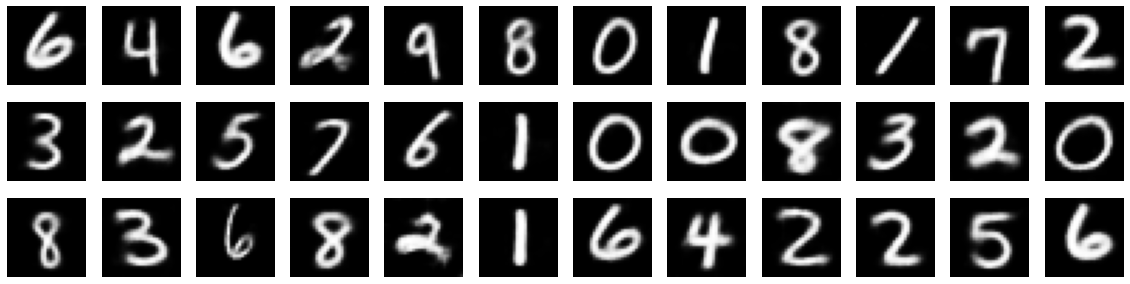

########################################################################################################################


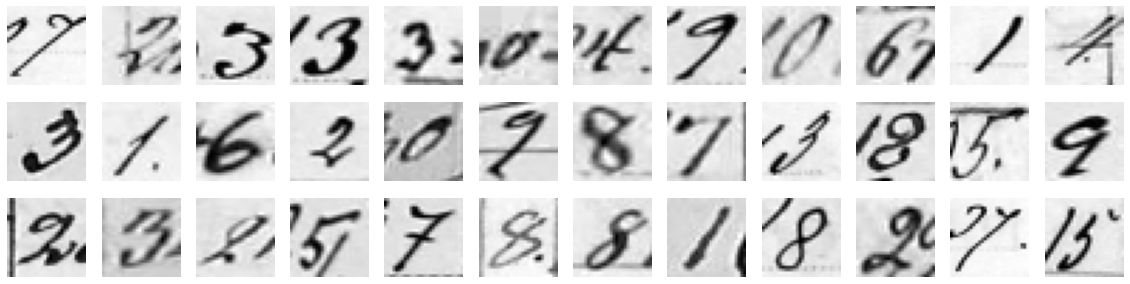

------------------------------------------------------------------------------------------------------------------------


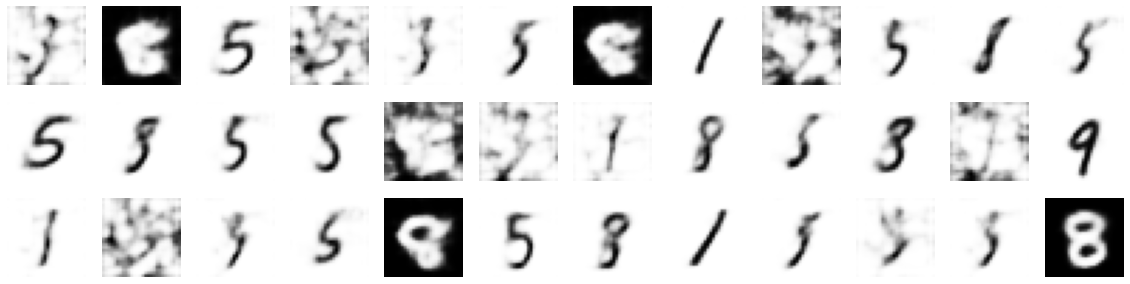

########################################################################################################################


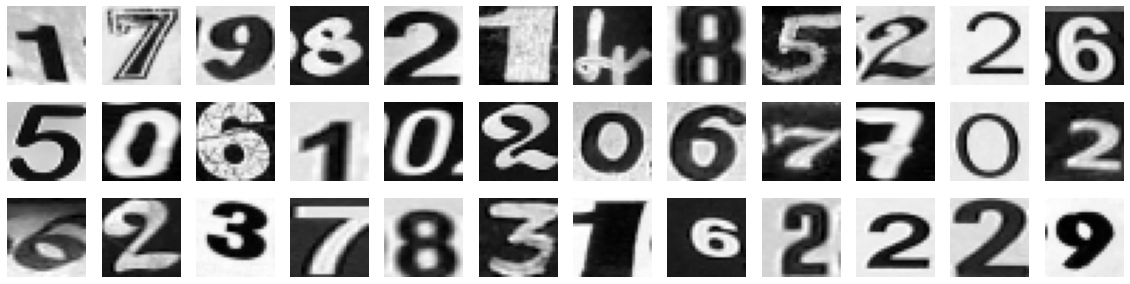

------------------------------------------------------------------------------------------------------------------------


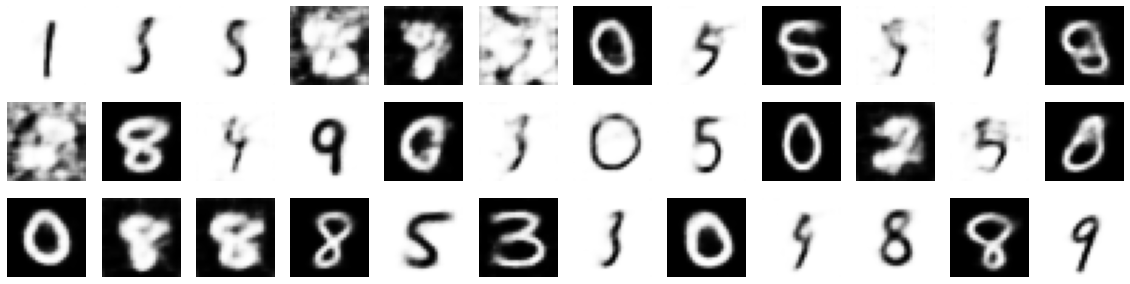

In [12]:
# test the quality of trained auto-encoder 
def test_projection(model, img_array):
    print('#'*120)
    selected = np.random.choice(img_array.shape[0], VIS_ROWS*VIS_COLS, replace = False)
    visualize_images(img_array, selected)
    imgs = img_array[selected]
    F = model.transform(imgs)
    img_re = model.inverse_transform(F)
    print('-'*120)
    visualize_images(img_re, np.arange(len(selected)) )

test_projection(ae, Xte)
test_projection(ae, dida_img)
test_projection(ae, ch74_img)

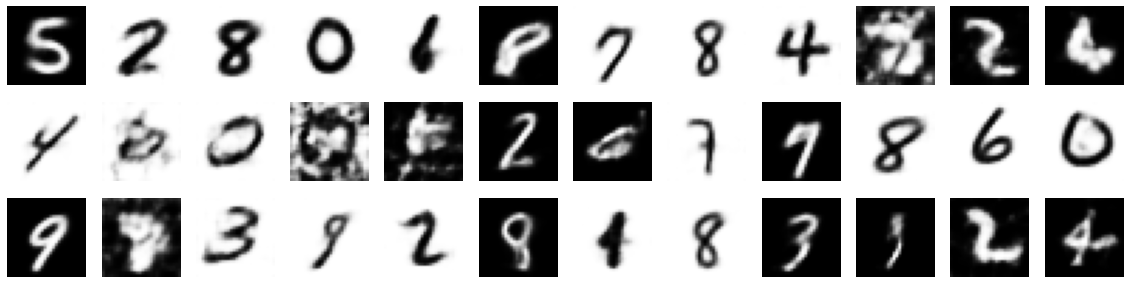

In [13]:
# try generation from the vae
generated = ae.model.sample(VIS_COLS * VIS_ROWS, device = 'cuda:1')
data = torch.flatten(generated, start_dim = 1).detach().cpu().numpy()
visualize_images(data, np.arange(len(data)))

########################################################################################################################


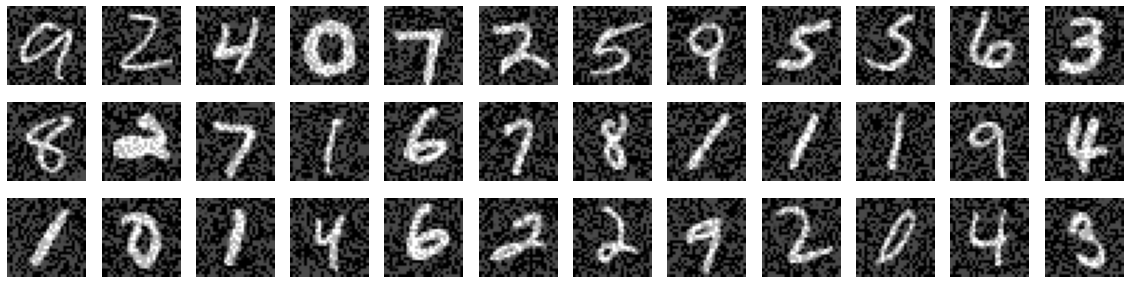

------------------------------------------------------------------------------------------------------------------------


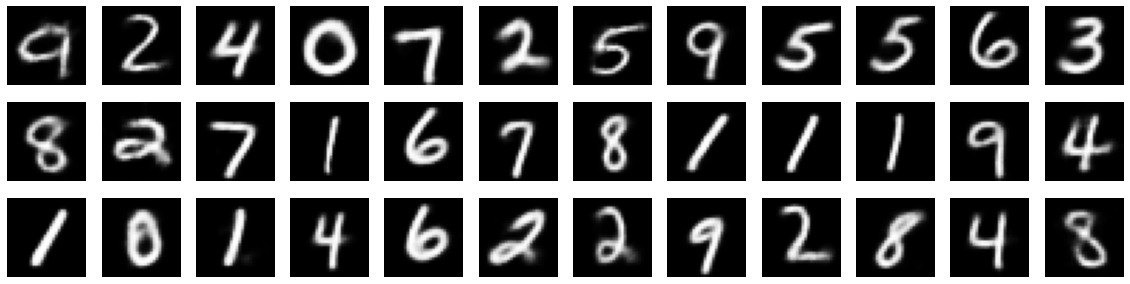

########################################################################################################################


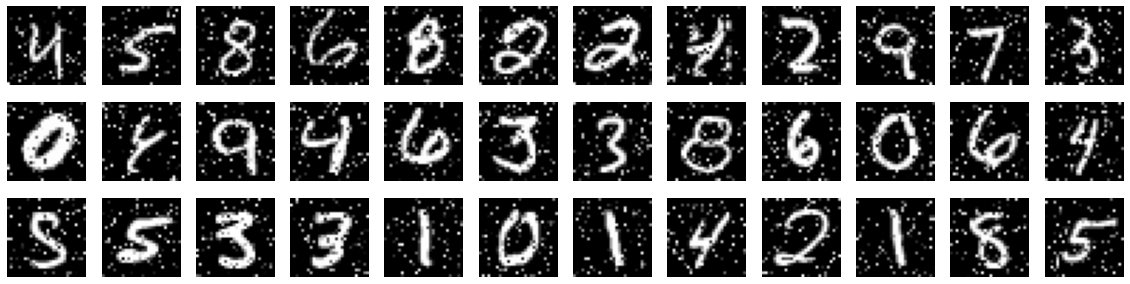

------------------------------------------------------------------------------------------------------------------------


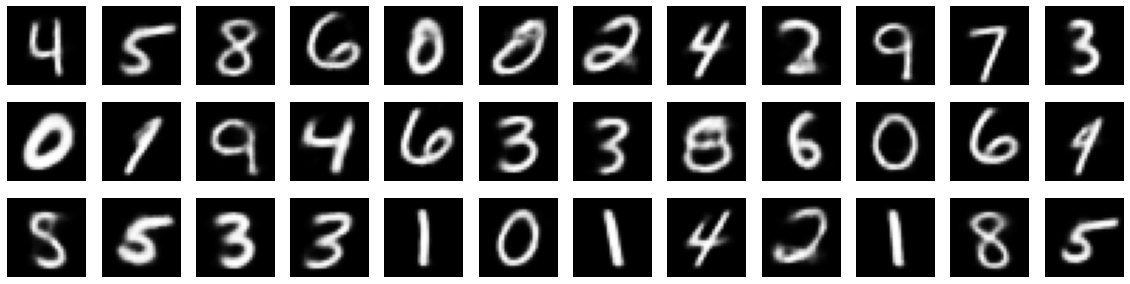

In [14]:
def gaussian_noise(data, scale, thresh):
    '''
    - add gaussian noise to data
    - assume each row is a sample
    '''
    noise = np.clip(np.random.normal(size = data.shape, scale = scale), -thresh, thresh)
    return data + noise 

def pixel_jitter(data, n, l, r):
    '''
    - random jitter some part of the input 
    - at most n of them (for each row), if n is float, then at most (100*n) %
    - the juttered value is from range l to r 
    '''
    N, D = data.shape 
    if isinstance(n, float):
        n = max(int(n*D) ,1)
    
    col_ind = np.concatenate([np.random.choice(D, size = n, replace = False) for _ in range(N)], axis = 0)
    row_ind = np.broadcast_to(np.arange(N).reshape(N,1), shape = (N,n) ).flatten()
    
    ret = data[:]
    ret[row_ind, col_ind] = np.random.uniform(size = row_ind.size) * (r-l) + l
    return ret


# try some noisy input and reconstruct 
mnist_gaussian = gaussian_noise(Xte, scale = 1, thresh = 0.2)
mnist_jitter = pixel_jitter(Xte, 0.1, 0, 1)

test_projection(ae, mnist_gaussian)
test_projection(ae, mnist_jitter)

# test the distance of input 




In [15]:
# visulize the space if 2d embedding
from scipy.stats import norm

if latent_dim ==2:
    n = 20
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    # decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            z = torch.from_numpy(z).to(dtype=torch.float32, device = 'cuda:1')
            x_decoded = ae.model.decode(z)[0][0].detach().cpu().numpy()
            digit = x_decoded.reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap = 'gray')
    plt.show() 
    